### ***Setup***

In [1]:
data_PATH = "./assets/original/CSV_Files/AODBData_2017_2022.csv"
weather_JSON_PATH = "./assets/original/JSON_Files/weather.json"
airports_JSON_PATH = "./assets/original/JSON_Files/airports.json"
result_PATH = "./assets/generated/res_departure.csv"
analysis_notebook_PATH = "./assets/generated/analysis_result.csv"
model_weights_PATH = "./assets/generated/model_weights/departure/"
after_pipeline_departure_PATH = "./assets/generated/after_pipeline_departure.csv"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

In [3]:
from data_preprocessing.Cleaner import Cleaner
from data_preprocessing.WeatherCollector import WeatherCollector
from data_preprocessing.FeatureExtractor import FeatureExtractor
from data_preprocessing.FeaturePreProcessing import FeaturePreProcessing
from data_preprocessing.CustomizeData import CustomizeData
from models.NeuralNetwork import NeuralNetwork
from models.RandomForest import RandomForest
from utils import *

In [4]:
DATASET = pd.read_csv(data_PATH, index_col=False, parse_dates=['ETOA', 'ETOD'])
DATASET

C:\Users\Admin\AppData\Local\Temp\ipykernel_20424\4156636361.py:1: DtypeWarning: Columns (7,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  DATASET = pd.read_csv(data_PATH, index_col=False, parse_dates=['ETOA', 'ETOD'])


,Arr_FlightNo,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,TMOA,...,On_Block,Dep_FlightNo,Dep_Callsign,Destination,Dep_ParkingStand,STOD,Gate,ETOD,Off_Block,Actual_Takeoff
0,SG 059,SEJ059,TCTJT,B738,VOML,C55L,PS,4,2.016123e+13,20161231223400,...,20161231224627,SG 058,SEJ058,VIJP,C55L,2.016123e+13,D12,20161231234000,2.016123e+13,2.017010e+13
1,EK 603,UAE603,A6ENC,B77W,OPKC,B23,PS,301,2.016123e+13,20161231212800,...,20161231213808,EK 041,UAE041,EGBB,B23,2.016123e+13,B24,20161231234500,2.016123e+13,2.017010e+13
2,EK 202,UAE202,A6EDM,A388,KJFK,F18,PS,304,2.016123e+13,20161231161837,...,20161231162700,EK 306,UAE306,ZBAA,F18,2.016123e+13,B13,20161231235000,2.016123e+13,2.017010e+13
3,EK 094,UAE094,A6EPB,B77W,LIPE,B24,PS,304,2.016123e+13,20161231221000,...,20161231221900,EK 388,UAE388,VVNB,B24,2.016123e+13,B26,20170101000000,2.016123e+13,2.017010e+13
4,EK 752,UAE752,A6EPI,B77W,GMMN,D03,PS,306,2.016123e+13,20161231213000,...,20161231213731,EK 101,UAE101,LIMC,D03,2.016123e+13,A10,20170101000000,2.016123e+13,2.017010e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974248,EK 020,UAE1C,A6EVA,A388,EGCC,A07,PS,305.0,2.022123e+13,20221231040245,...,20221231041123,EK 011,UAE9KC,EGKK,A07,2.022123e+13,A23,20221231233500,2.022123e+13,2.022123e+13
974249,EK 074,UAE65W,A6EVL,A388,LFPG,F08,PS,310.0,2.022123e+13,20221231194142,...,20221231195130,EK 362,UAE362,ZGGG,F08,2.022123e+13,C13,20221231232500,2.022123e+13,2.022123e+13
974250,EK 050,UAE8VC,A6EON,A388,EDDM,D08,PS,301.0,2.022123e+13,20221231194258,...,20221231195335,EK 231,UAE3MX,KIAD,D08,2.022123e+13,A15,20221231233500,2.022123e+13,2.022123e+13
974251,EK 040,UAE61H,A6ENA,B77W,EGBB,B14,PS,306.0,2.022123e+13,20221231201657,...,20221231202717,EK 368,UAE368,WADD,B14,2.022123e+13,B6,20221231233500,2.022123e+13,2.022123e+13


### ***Data Cleaning***

In [5]:
columns_to_drop = ['ID.1', 'ID.2']

illogical_order_cols = [
    ['%Y%m%d%H%M%S', ['Off_Block', 'Actual_Takeoff']],
    ['%Y%m%d%H%M%S', ['Landing_Time', 'On_Block']]
]

columns_to_check = ['Origin', 'Destination']
values_to_drop = ['LOCL', 'ZZZF']

In [6]:
cleaner = Cleaner(columns_to_drop=columns_to_drop, illogical_order_cols=illogical_order_cols, columns_to_check=columns_to_check, values_to_drop=values_to_drop)

### ***Weather Collecting***

In [7]:
new_column_names = ['Time', 'Temperature', 'Dew Point', 'Humidity', 'Wind',
 'Wind Speed', 'Wind Gust', 'Pressure', 'Precip.', 'Condition']
datetime_column = 'ETOD'
initial_columns = list(DATASET.columns)

In [8]:
weather_collector = WeatherCollector(
    weather_JSON_PATH=weather_JSON_PATH, datetime_column=datetime_column, \
    initial_columns=initial_columns, \
    new_column_names=new_column_names)

### ***Feature Engineering***

In [9]:
airport_json_data_path = airports_JSON_PATH
DXB_lat = 25.2527999878; DXB_lon = 55.3643989563
origin_df_col_name = 'Origin'; dest_df_col_name = 'Destination'
new_distance_cols_names = ['Origin_Dubai_Distance', 'Dubai_Dest_Distance']
col_name_to_extract_airline_from = 'Arr_FlightNo'; extracted_airline_col_name = 'Airline'
relevant_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
isHoliday_column_name = 'isHoliday'
col_to_extract_holiday_from = 'Actual_Takeoff'

In [10]:
feature_extractor = FeatureExtractor(airport_json_data_path=airport_json_data_path, 
                                     airport_lat=DXB_lat, airport_lon=DXB_lon,
                                     origin_df_col_name=origin_df_col_name, dest_df_col_name=dest_df_col_name, \
                                     new_distance_cols_names=new_distance_cols_names, \
                                     col_name_to_extract_airline_from=col_name_to_extract_airline_from, \
                                     extracted_airline_col_name=extracted_airline_col_name, 
                                     relevant_years=relevant_years, \
                                     isHoliday_column_name=isHoliday_column_name, \
                                     col_to_extract_holiday_from=col_to_extract_holiday_from , \
                                    )

### ***Customize Data***

In [11]:
date_col1_to_calc_delay = "STOD"
date_col2_to_calc_delay = "Actual_Takeoff"
date_format = "%Y%m%d%H%M%S"
delay_col_name = "Delay"
col_to_set_index = "STOD"
index_col_name = "Date_Time"
date_range = ("2021-01-01", "2022-12-31")
# date_range = ("2017-01-01", "2019-12-31")
# date_range = ("2017-01-01", "2022-12-31")

In [12]:
customized_data = CustomizeData(date_col1_to_calc_delay=date_col1_to_calc_delay,
                                date_col2_to_calc_delay=date_col2_to_calc_delay,
                                date_format=date_format,
                                delay_col_name=delay_col_name,
                                col_to_set_index=col_to_set_index,
                                index_col_name=index_col_name,
                                date_range=date_range
                                )

In [13]:
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
        "hour",
        "weekend",
    ],
)
cyclicf = CyclicalFeatures(
    variables=["month", "hour"],
    drop_original=False,
)

### ***Feature PreProcessing***

In [14]:
categories = ['Airline', 'AC_Type', 'Flight_Type', 'Arr_ParkingStand', 'Dep_ParkingStand', 'Gate']
delay_column = 'Delay'

In [15]:
feature_preprocessor = FeaturePreProcessing(encoding_method='mean_encoding',
                                            categories=categories, delay_column=delay_column, pareto_percentage=0.2)

### ***Pipeline***

In [16]:
pipeline = Pipeline([
    ("Cleaning Data", cleaner),
    ("Collecting Weather", weather_collector),
    ("Feature Engineering", feature_extractor),
    ("Customizing Data", customized_data),
    ("datetime_features", dtf),
    ("Periodic", cyclicf),
    ("PreProcessing Data", feature_preprocessor),
    ("Drop missing data", DropMissingData())
])

In [17]:
DATASET_transformed = pipeline.fit_transform(DATASET)
DATASET_transformed.to_csv(result_PATH, index=False)
DATASET_transformed

Cleaning Data...
Dropped: 89557 rows.



Extracting new features...

Customizing Data...

PreProcessing Data...


,Arr_FlightNo,Airline,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,...,month_sin,month_cos,hour_sin,hour_cos,Airline_Mean_Delay,AC_Type_Mean_Delay,Flight_Type_Mean_Delay,Arr_ParkingStand_Mean_Delay,Dep_ParkingStand_Mean_Delay,Gate_Mean_Delay
Date_Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,EK 2816,EK,UAE2816,A6EPS,B77W,OERK,B27,PS,302,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,27.953374,26.609016,31.25125,28.378676,27.789500,27.789500
2021-01-01 00:05:00,PS 373,PS,AUI373,URPSW,B738,UKBB,F13,PS,305,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,24.234783,34.582443,31.25125,27.392559,26.401535,26.328358
2021-01-01 00:10:00,FZ 602,FZ,FDB602,A6FEB,B738,HDAM,E11L,PS,6,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,32.916195,34.582443,31.25125,33.994524,33.916561,30.679564
2021-01-01 00:20:00,EK 734,EK,UAE734,A6EGY,B77W,HSSS,F09,PS,314,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,27.953374,26.609016,31.25125,25.959085,24.677160,24.677160
2021-01-01 00:25:00,RA 229,RA,RNA229,9NAKX,A320,VNKT,E12R,PS,6,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,32.883946,33.747235,31.25125,29.634710,29.420111,31.905626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,EK 567,EK,UAE6N,A6ECV,B77W,VOBL,A08,PS,303.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,26.609016,31.25125,31.598734,30.728557,30.728557
2022-12-31 22:45:00,EK 148,EK,UAE31V,A6EEH,A388,EHAM,B21R,PS,312.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,34.492673,31.25125,34.946921,35.874720,28.828711
2022-12-31 22:50:00,EK 248,EK,UAE248,A6EWC,B77L,SAEZ,A04,PS,309.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,23.734228,31.25125,34.010088,31.578288,31.578288


Dep Customized

In [18]:
DATASET_transformed = pd.read_csv(result_PATH)
DATASET_transformed

,Arr_FlightNo,Airline,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,...,month_sin,month_cos,hour_sin,hour_cos,Airline_Mean_Delay,AC_Type_Mean_Delay,Flight_Type_Mean_Delay,Arr_ParkingStand_Mean_Delay,Dep_ParkingStand_Mean_Delay,Gate_Mean_Delay
0,EK 2816,EK,UAE2816,A6EPS,B77W,OERK,B27,PS,302.0,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,27.953374,26.609016,31.25125,28.378676,27.789500,27.789500
1,PS 373,PS,AUI373,URPSW,B738,UKBB,F13,PS,305.0,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,24.234783,34.582443,31.25125,27.392559,26.401535,26.328358
2,FZ 602,FZ,FDB602,A6FEB,B738,HDAM,E11L,PS,6.0,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,32.916195,34.582443,31.25125,33.994524,33.916561,30.679564
3,EK 734,EK,UAE734,A6EGY,B77W,HSSS,F09,PS,314.0,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,27.953374,26.609016,31.25125,25.959085,24.677160,24.677160
4,RA 229,RA,RNA229,9NAKX,A320,VNKT,E12R,PS,6.0,2.020123e+13,...,5.000000e-01,0.866025,0.000000,1.000000,32.883946,33.747235,31.25125,29.634710,29.420111,31.905626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250569,EK 567,EK,UAE6N,A6ECV,B77W,VOBL,A08,PS,303.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,26.609016,31.25125,31.598734,30.728557,30.728557
250570,EK 148,EK,UAE31V,A6EEH,A388,EHAM,B21R,PS,312.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,34.492673,31.25125,34.946921,35.874720,28.828711
250571,EK 248,EK,UAE248,A6EWC,B77L,SAEZ,A04,PS,309.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,23.734228,31.25125,34.010088,31.578288,31.578288
250572,EK 547,EK,UAE547,A6ENQ,B77W,VOMM,F05,PS,304.0,2.022123e+13,...,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,26.609016,31.25125,25.939698,25.989677,25.987952


In [19]:
df = DATASET_transformed.copy()

In [20]:
df = transform_datetime(df, "On_Block")

In [21]:
keyword="On_Block"
count_columns_start_with(df=df, keyword=keyword)
[x for x in df.columns.tolist() if x.startswith(keyword)]

7 columns start with On_Block


['On_Block_month',
 'On_Block_hour',
 'On_Block_weekend',
 'On_Block_month_sin',
 'On_Block_month_cos',
 'On_Block_hour_sin',
 'On_Block_hour_cos']

In [22]:
# df['On_Block_hour']
# df['On_Block_month_sin']
df['On_Block_hour_cos']
# df['On_Block_hour_sin']

0         0.203456
1         0.962917
2        -0.576680
3         0.682553
4         1.000000
            ...   
250569    0.203456
250570    0.460065
250571    0.203456
250572    0.682553
250573    0.854419
Name: On_Block_hour_cos, Length: 250574, dtype: float64

In [23]:
print('before ', df.shape)
df.dropna(inplace=True)
print('after ', df.shape)  

before  (250574, 57)
after  (250574, 57)


In [24]:
after_pipeline_departure_PATH = "./assets/generated/after_pipeline_departure.csv"
df.to_csv(after_pipeline_departure_PATH, index=False)

### ***Exploratory Analysis*** 

In [25]:
DATASET_transformed = pd.read_csv(after_pipeline_departure_PATH)
DATASET_transformed

,Arr_FlightNo,Airline,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,...,Arr_ParkingStand_Mean_Delay,Dep_ParkingStand_Mean_Delay,Gate_Mean_Delay,On_Block_month,On_Block_hour,On_Block_weekend,On_Block_month_sin,On_Block_month_cos,On_Block_hour_sin,On_Block_hour_cos
0,EK 2816,EK,UAE2816,A6EPS,B77W,OERK,B27,PS,302.0,2.020123e+13,...,28.378676,27.789500,27.789500,12,18,0,-2.449294e-16,1.0,-9.790841e-01,0.203456
1,PS 373,PS,AUI373,URPSW,B738,UKBB,F13,PS,305.0,2.020123e+13,...,27.392559,26.401535,26.328358,12,22,0,-2.449294e-16,1.0,-2.697968e-01,0.962917
2,FZ 602,FZ,FDB602,A6FEB,B738,HDAM,E11L,PS,6.0,2.020123e+13,...,33.994524,33.916561,30.679564,12,15,0,-2.449294e-16,1.0,-8.169699e-01,-0.576680
3,EK 734,EK,UAE734,A6EGY,B77W,HSSS,F09,PS,314.0,2.020123e+13,...,25.959085,24.677160,24.677160,12,20,0,-2.449294e-16,1.0,-7.308360e-01,0.682553
4,RA 229,RA,RNA229,9NAKX,A320,VNKT,E12R,PS,6.0,2.020123e+13,...,29.634710,29.420111,31.905626,12,23,0,-2.449294e-16,1.0,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250569,EK 567,EK,UAE6N,A6ECV,B77W,VOBL,A08,PS,303.0,2.022123e+13,...,31.598734,30.728557,30.728557,12,18,1,-2.449294e-16,1.0,-9.790841e-01,0.203456
250570,EK 148,EK,UAE31V,A6EEH,A388,EHAM,B21R,PS,312.0,2.022123e+13,...,34.946921,35.874720,28.828711,12,19,1,-2.449294e-16,1.0,-8.878852e-01,0.460065
250571,EK 248,EK,UAE248,A6EWC,B77L,SAEZ,A04,PS,309.0,2.022123e+13,...,34.010088,31.578288,31.578288,12,18,1,-2.449294e-16,1.0,-9.790841e-01,0.203456
250572,EK 547,EK,UAE547,A6ENQ,B77W,VOMM,F05,PS,304.0,2.022123e+13,...,25.939698,25.989677,25.987952,12,20,1,-2.449294e-16,1.0,-7.308360e-01,0.682553


In [26]:
df = DATASET_transformed.copy()

categories = ['Airline', 'AC_Type', 'Flight_Type', 'Arr_ParkingStand', 'Dep_ParkingStand', 'Gate']
columns_to_drop = categories + ['Arr_FlightNo', 'ETOD', 'month', 'STOD_SEC', 'Condition', 'Dep_Callsign', 'TMOA', 'Wind Gust', 
                                'Precip.', 'Wind', 'STOA', 'Origin', 'Actual_Takeoff_SEC', 'AC_Registration',
                                'Origin_Dubai_Distance', 'STOD', 'Time', 'Landing_Time', 'Dep_FlightNo', 'Off_Block', 'hour', 'Destination', 'Dew Point', 'Humidity', 'AC_Type', 'ETOA',  'Arr_Callsign', 'Actual_Takeoff', 
                                'On_Block_month', 'On_Block_hour', 'On_Block_weekend', 'Delay']


y = df['Delay']
X = df.drop(columns=columns_to_drop)

count_columns_start_with(df, "AC_Type")
count_columns_start_with(df, "Airline")
show_columns(X)
X


2 columns start with AC_Type
2 columns start with Airline
'Baggage_Belt','Temperature','Wind Speed','Pressure','isHoliday','weekend','month_sin','month_cos','hour_sin','hour_cos','Airline_Mean_Delay','AC_Type_Mean_Delay','Flight_Type_Mean_Delay','Arr_ParkingStand_Mean_Delay','Dep_ParkingStand_Mean_Delay','Gate_Mean_Delay','On_Block_month_sin','On_Block_month_cos','On_Block_hour_sin','On_Block_hour_cos',

,Baggage_Belt,Temperature,Wind Speed,Pressure,isHoliday,weekend,month_sin,month_cos,hour_sin,hour_cos,Airline_Mean_Delay,AC_Type_Mean_Delay,Flight_Type_Mean_Delay,Arr_ParkingStand_Mean_Delay,Dep_ParkingStand_Mean_Delay,Gate_Mean_Delay,On_Block_month_sin,On_Block_month_cos,On_Block_hour_sin,On_Block_hour_cos
0,302.0,70,6,30.01,1,0,5.000000e-01,0.866025,0.000000,1.000000,27.953374,26.609016,31.25125,28.378676,27.789500,27.789500,-2.449294e-16,1.0,-9.790841e-01,0.203456
1,305.0,70,6,30.01,1,0,5.000000e-01,0.866025,0.000000,1.000000,24.234783,34.582443,31.25125,27.392559,26.401535,26.328358,-2.449294e-16,1.0,-2.697968e-01,0.962917
2,6.0,70,6,30.01,1,0,5.000000e-01,0.866025,0.000000,1.000000,32.916195,34.582443,31.25125,33.994524,33.916561,30.679564,-2.449294e-16,1.0,-8.169699e-01,-0.576680
3,314.0,70,6,30.01,1,0,5.000000e-01,0.866025,0.000000,1.000000,27.953374,26.609016,31.25125,25.959085,24.677160,24.677160,-2.449294e-16,1.0,-7.308360e-01,0.682553
4,6.0,70,6,30.01,1,0,5.000000e-01,0.866025,0.000000,1.000000,32.883946,33.747235,31.25125,29.634710,29.420111,31.905626,-2.449294e-16,1.0,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250569,303.0,72,3,30.19,0,1,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,26.609016,31.25125,31.598734,30.728557,30.728557,-2.449294e-16,1.0,-9.790841e-01,0.203456
250570,312.0,72,3,30.19,0,1,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,34.492673,31.25125,34.946921,35.874720,28.828711,-2.449294e-16,1.0,-8.878852e-01,0.460065
250571,309.0,72,3,30.19,0,1,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,23.734228,31.25125,34.010088,31.578288,31.578288,-2.449294e-16,1.0,-9.790841e-01,0.203456
250572,304.0,72,3,30.19,0,1,-2.449294e-16,1.000000,-0.269797,0.962917,27.953374,26.609016,31.25125,25.939698,25.989677,25.987952,-2.449294e-16,1.0,-7.308360e-01,0.682553


### ***Splitting Data***

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Baggage_Belt,Temperature,Wind Speed,Pressure,isHoliday,weekend,month_sin,month_cos,hour_sin,hour_cos,Airline_Mean_Delay,AC_Type_Mean_Delay,Flight_Type_Mean_Delay,Arr_ParkingStand_Mean_Delay,Dep_ParkingStand_Mean_Delay,Gate_Mean_Delay,On_Block_month_sin,On_Block_month_cos,On_Block_hour_sin,On_Block_hour_cos
46871,6.0,97,5,29.54,0,0,-8.660254e-01,-5.000000e-01,-7.308360e-01,0.682553,25.311581,27.056533,31.25125,31.804886,31.858209,31.890367,-8.660254e-01,-5.000000e-01,-0.887885,0.460065
172581,4.0,108,13,29.34,0,1,-5.000000e-01,-8.660254e-01,-6.310879e-01,-0.775711,17.652778,27.056533,31.25125,39.682540,38.443096,39.190624,-5.000000e-01,-8.660254e-01,-0.398401,-0.917211
70901,304.0,81,3,29.98,0,0,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000,32.916195,37.674147,31.25125,36.852378,38.617139,29.905124,-5.000000e-01,8.660254e-01,-0.887885,0.460065
84440,7.0,70,3,30.13,0,0,-2.449294e-16,1.000000e+00,8.169699e-01,-0.576680,41.108084,33.747235,31.25125,39.682540,38.443096,39.190624,-2.449294e-16,1.000000e+00,0.816970,-0.576680
35231,8.0,100,10,29.54,0,0,1.224647e-16,-1.000000e+00,-9.790841e-01,0.203456,20.886802,29.080420,31.25125,30.836896,30.437992,30.437992,1.224647e-16,-1.000000e+00,-0.997669,-0.068242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,306.0,77,5,29.84,0,0,1.000000e+00,6.123234e-17,8.878852e-01,0.460065,27.953374,34.492673,31.25125,33.109375,34.238494,26.430696,1.000000e+00,6.123234e-17,-0.730836,0.682553
103694,309.0,68,5,29.93,0,0,8.660254e-01,5.000000e-01,7.308360e-01,0.682553,27.953374,26.609016,31.25125,23.823129,23.774377,26.430696,8.660254e-01,5.000000e-01,0.000000,1.000000
131932,6.0,86,5,29.75,0,0,8.660254e-01,-5.000000e-01,3.984011e-01,-0.917211,32.916195,34.582443,31.25125,36.145591,36.146545,30.829979,8.660254e-01,-5.000000e-01,0.269797,0.962917
146867,302.0,82,9,29.54,0,0,5.000000e-01,-8.660254e-01,9.790841e-01,0.203456,27.953374,23.734228,31.25125,24.600746,24.176753,24.176753,5.000000e-01,-8.660254e-01,0.269797,0.962917


In [28]:
X_train.shape, X_test.shape

((200459, 20), (50115, 20))

In [29]:
y_train.shape, y_test.shape

((200459,), (50115,))

### ***Feature Scaling***

In [30]:
columns_to_scale = ['Baggage_Belt', 'Temperature', 'Wind Speed', 'Pressure','weekend', 'month_sin', 'month_cos',
                    'hour_sin', 'hour_cos', 'On_Block_month_sin', 'On_Block_month_cos', 'On_Block_hour_sin', 'On_Block_hour_cos']
columns_to_scale

['Baggage_Belt',
 'Temperature',
 'Wind Speed',
 'Pressure',
 'weekend',
 'month_sin',
 'month_cos',
 'hour_sin',
 'hour_cos',
 'On_Block_month_sin',
 'On_Block_month_cos',
 'On_Block_hour_sin',
 'On_Block_hour_cos']

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler.transform(X_test[columns_to_scale])

X_train.drop(columns_to_scale, axis=1, inplace=True)
X_train[columns_to_scale] = X_train_scaled

X_test.drop(columns_to_scale, axis=1, inplace=True)
X_test[columns_to_scale] = X_test_scaled

X_train

,isHoliday,Airline_Mean_Delay,AC_Type_Mean_Delay,Flight_Type_Mean_Delay,Arr_ParkingStand_Mean_Delay,Dep_ParkingStand_Mean_Delay,Gate_Mean_Delay,Baggage_Belt,Temperature,Wind Speed,Pressure,weekend,month_sin,month_cos,hour_sin,hour_cos,On_Block_month_sin,On_Block_month_cos,On_Block_hour_sin,On_Block_hour_cos
46871,0,25.311581,27.056533,31.25125,31.804886,31.858209,31.890367,-0.982553,1.074321,-0.674180,-0.694717,-0.649854,-1.138032,-0.817377,-1.198248,0.883809,-1.138034,-0.817101,-1.094904,0.477079
172581,0,17.652778,27.056533,31.25125,39.682540,38.443096,39.190624,-0.995745,2.058889,1.331451,-1.348842,1.538807,-0.614554,-1.334980,-1.057588,-1.225754,-0.614496,-1.334643,-0.393676,-1.509291
70901,0,32.916195,37.674147,31.25125,36.852378,38.617139,29.905124,0.983095,-0.357776,-1.175587,0.744359,-0.649854,-0.614554,1.114347,-0.167664,1.343036,-0.614496,1.114389,-1.094904,0.477079
84440,0,41.108084,33.747235,31.25125,39.682540,38.443096,39.190624,-0.975957,-1.342343,-1.175587,1.234953,-0.649854,0.100529,1.303803,0.984382,-0.937831,0.100671,1.303822,1.347447,-1.018162
35231,0,20.886802,29.080420,31.25125,30.836896,30.437992,30.437992,-0.969361,1.342840,0.579339,-0.694717,-0.649854,0.100529,-1.524437,-1.548313,0.190735,0.100671,-1.524076,-1.252178,-0.284870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0,27.953374,34.492673,31.25125,33.109375,34.238494,26.430696,0.996287,-0.715801,-0.674180,0.286471,-0.649854,1.530697,-0.110317,1.084382,0.561952,1.531005,-0.110127,-0.869917,0.797961
103694,0,27.953374,26.609016,31.25125,23.823129,23.774377,26.430696,1.016076,-1.521356,-0.674180,0.580828,-0.649854,1.339091,0.596743,0.862920,0.883809,1.339377,0.596848,0.177068,1.255797
131932,0,32.916195,34.582443,31.25125,36.145591,36.146545,30.829979,-0.982553,0.089754,-0.674180,-0.007885,-0.649854,1.339091,-0.817377,0.394139,-1.430452,1.339377,-0.817101,0.563575,1.202315
146867,0,27.953374,23.734228,31.25125,24.600746,24.176753,24.176753,0.969903,-0.268270,0.328635,-0.694717,-0.649854,0.815613,-1.334980,1.212986,0.190735,0.815838,-1.334643,0.563575,1.202315


## ***Models***

### ***Deep Neural Network***

In [135]:
layer_sizes = [10, 4]
input_shape = (X_train.shape[1],)
activation_functions = ["relu" for x in layer_sizes]
output_layer_size = 1

epochs = 100
batch_size = 32
lr = 0.001
loss = 'mean_squared_error'
early_stopping_bool = True
monitor='val_loss'
patience = 5
restore_best_weights = True
model_checkpoint_bool = True
model_weights_PATH = model_weights_PATH + 'model1.h5'
save_best_weights_only = True

Create a Neural Network 

In [136]:
neural_network = NeuralNetwork(
    X_train, X_test, y_train, y_test, model_weights_PATH=model_weights_PATH)

Create a model

In [137]:
model = neural_network.create_model(
    layer_sizes, input_shape, activation_functions, output_layer_size)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                1660      
                                                                 
 dense_7 (Dense)             (None, 4)                 44        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,709
Trainable params: 1,709
Non-trainable params: 0
_________________________________________________________________
None


Run Model

In [138]:
history = neural_network.run_model(model=model,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   lr=lr,
                                   loss=loss,
                                   early_stopping_bool=early_stopping_bool,
                                   monitor=monitor,
                                   patience=patience,
                                   restore_best_weights=restore_best_weights, 
                                   model_checkpoint_bool=model_checkpoint_bool,
                                   save_best_weights_only=save_best_weights_only
                                   )

Epoch 1/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1600.7585 - val_loss: 1737.6560
Epoch 2/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1527.7316 - val_loss: 1716.8839
Epoch 3/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1504.3009 - val_loss: 1696.5768
Epoch 4/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1487.6450 - val_loss: 1681.4008
Epoch 5/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1476.5969 - val_loss: 1671.1921
Epoch 6/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1464.2532 - val_loss: 1657.7748
Epoch 7/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1437.9883 - val_loss: 1627.2008
Epoch 8/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1394.7935 - val_loss: 1575.3429
Epoch 9/100
6265/6265 [==============================] - 8s 1ms/step - loss: 1334.6068 - val_loss: 1522.8268
Epoch 10/100
6265/6

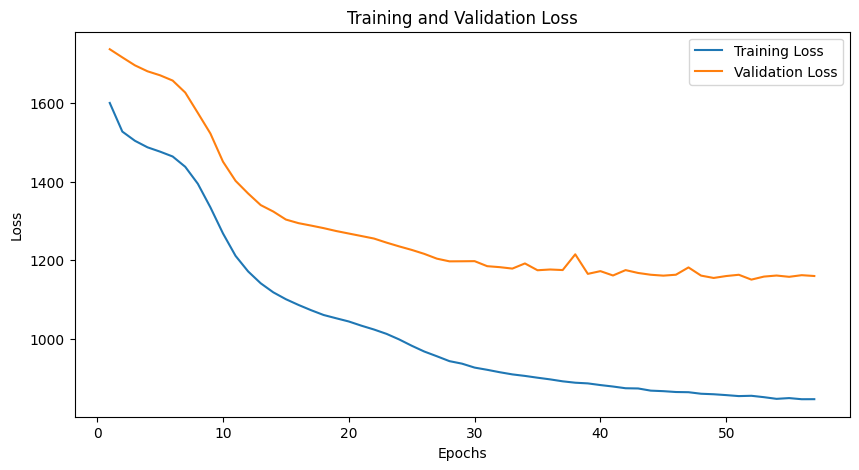

In [139]:
neural_network.plot_losses(history)

Predict

In [140]:
y_pred = neural_network.predict()

1567/1567 [==============================] - 2s 946us/step


Evaluate

In [141]:
evaluate_model(y_test, y_pred)

R2: 0.37001796758680394 
MSE: 1150.4437308856757 
MAE: 14.167392952968102 
MAPE: 148461888736726.0 
RMSE: 33.918191739620724


Show Error

In [142]:
show_error(y_test, y_pred)

,Actual,Predicted,Error
0,31,33.0,2.0
1,26,38.0,12.0
2,20,21.0,1.0
3,20,35.0,15.0
4,32,29.0,3.0
...,...,...,...
50110,51,29.0,22.0
50111,99,28.0,71.0
50112,15,23.0,8.0
50113,16,22.0,6.0


### ***Deep Neural Network***

In [32]:
layer_sizes = [10, 4]
input_shape = (X_train.shape[1],)
activation_functions = ["relu" for x in layer_sizes]
output_layer_size = 1

epochs = 100
batch_size = 32
lr = 0.001
loss = 'mean_squared_error'
early_stopping_bool = True
monitor='val_loss'
patience = 5
restore_best_weights=True
model_checkpoint_bool = True
model_weights_PATH = model_weights_PATH + 'model2.h5'
save_best_weights_only=True

Create a Neural Network 

In [33]:
neural_network = NeuralNetwork(
    X_train, X_test, y_train, y_test, model_weights_PATH=model_weights_PATH)

Create a model

In [34]:
model = neural_network.create_model(
    layer_sizes, input_shape, activation_functions, output_layer_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 126       
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 159
Trainable params: 159
Non-trainable params: 0
_________________________________________________________________
None


Run Model

In [35]:
history = neural_network.run_model(model=model,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   lr=lr,
                                   loss=loss,
                                   early_stopping_bool=early_stopping_bool,
                                   monitor=monitor,
                                   patience=patience,
                                   restore_best_weights=restore_best_weights, model_checkpoint_bool=model_checkpoint_bool,
                                   save_best_weights_only=save_best_weights_only)

Epoch 1/100
6265/6265 [==============================] - 9s 1ms/step - loss: 1556.3951 - val_loss: 1734.2051
Epoch 2/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1536.3527 - val_loss: 1728.0908
Epoch 3/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1532.3967 - val_loss: 1728.8875
Epoch 4/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1531.0378 - val_loss: 1726.5265
Epoch 5/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1530.6080 - val_loss: 1725.6656
Epoch 6/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1530.1304 - val_loss: 1725.2354
Epoch 7/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1529.9897 - val_loss: 1726.6570
Epoch 8/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1529.5963 - val_loss: 1724.9646
Epoch 9/100
6265/6265 [==============================] - 7s 1ms/step - loss: 1528.9395 - val_loss: 1723.0269
Epoch 10/100
6265/6

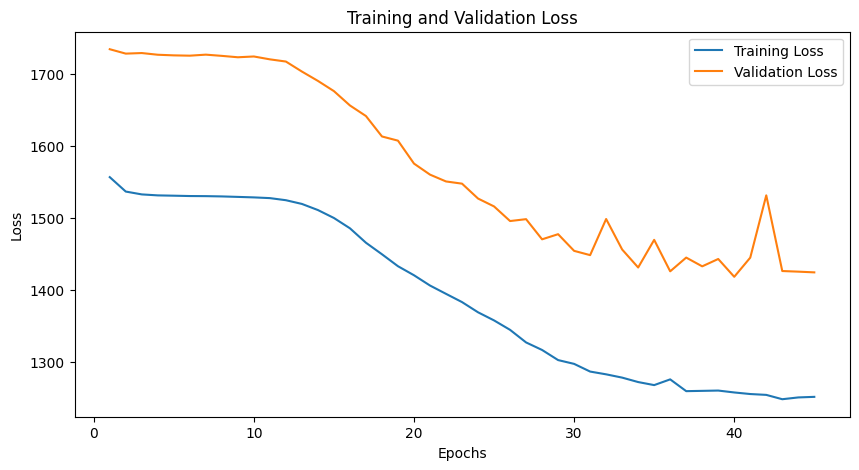

In [36]:
neural_network.plot_losses(history)

Predict

In [37]:
y_pred = neural_network.predict()

1567/1567 [==============================] - 2s 911us/step


Evaluate

In [38]:
evaluate_model(y_test, y_pred)

R2: 0.22357802800819526 
MSE: 1417.8655013037087 
MAE: 16.231733596057314 
MAPE: 192669426836120.34 
RMSE: 37.654554854674736


Show Error

In [39]:
show_error(y_test, y_pred)

,Actual,Predicted,Error
0,31,42.0,11.0
1,26,34.0,8.0
2,20,26.0,6.0
3,20,47.0,27.0
4,32,26.0,6.0
...,...,...,...
50110,51,29.0,22.0
50111,99,27.0,72.0
50112,15,22.0,7.0
50113,16,23.0,7.0


### ***Random Forest Model***

In [143]:
n_estimators=100
random_state=0
max_depth=None
min_samples_split=10
min_samples_leaf=5
verbose=0

Create Model

In [144]:
random_forest = RandomForest(X_train, X_test, y_train, y_test)

Run Model

In [145]:
regressor = random_forest.run_model(n_estimators=n_estimators,
                                    random_state=random_state,
                                    max_depth=None,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.0min finished


Predict

In [146]:
y_pred = random_forest.predict(regressor)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished


In [151]:
random_forest.show_predicted(y_pred)

array([[30.11162997, 31.        ],
       [24.53981381, 26.        ],
       [21.35120199, 20.        ],
       ...,
       [17.7650868 , 15.        ],
       [16.01308908, 16.        ],
       [23.27594449, 33.        ]])

Evaluate Model

In [152]:
evaluate_model(y_pred,y_test)

R2: -1.7726930015581264 
MSE: 1236.81391865776 
MAE: 13.64841252112656 
MAPE: 0.4213355355491743 
RMSE: 35.168365311139496


Feature Importances

In [153]:
feature_importance_df = random_forest.feature_importances(regressor)
feature_importance_df

,Feature,Importance
160,hour_cos,0.150099
163,On_Block_hour_sin,0.138154
159,hour_sin,0.136675
164,On_Block_hour_cos,0.106966
153,Temperature,0.073370
...,...,...
46,Arr_ParkingStand_encoded_B15,0.000065
124,Gate_encoded_B11,0.000063
2,Airline_encoded_AF,0.000047
85,Dep_ParkingStand_encoded_B15,0.000038


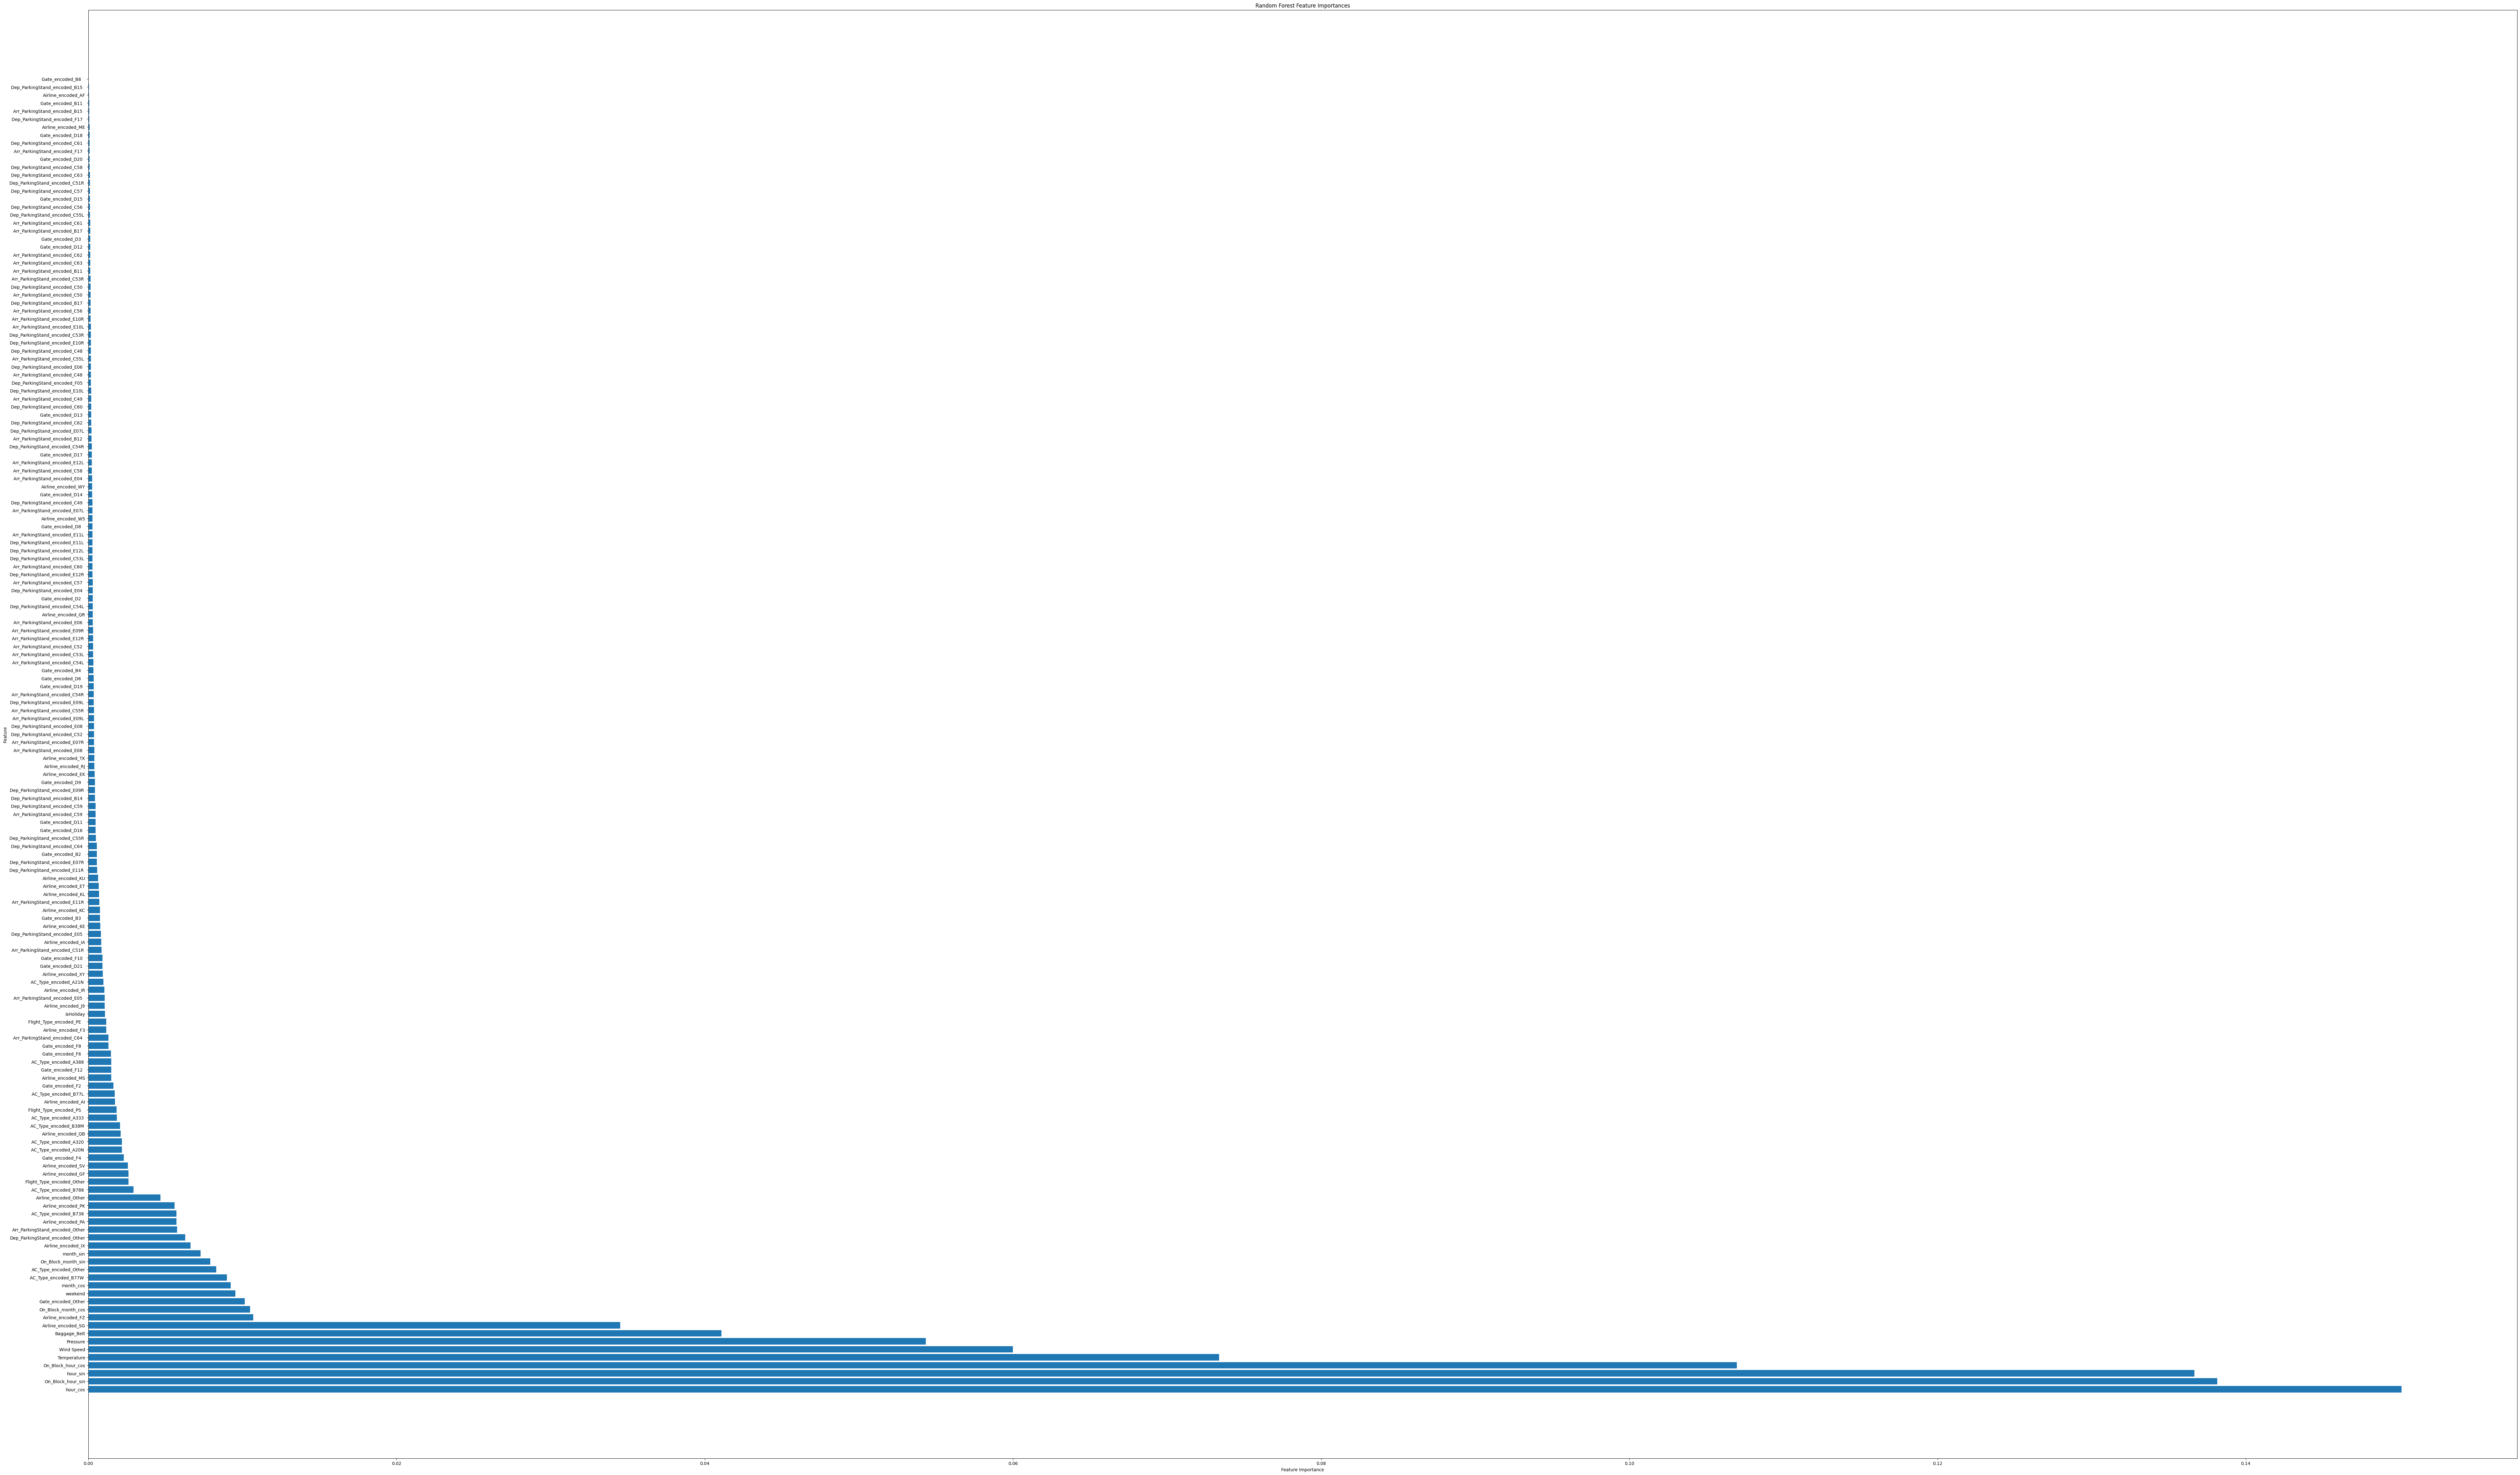

In [154]:
random_forest.plot_feature_importances(feature_importance_df, figsize=(100, 60))

### ***Linear Regression Model***

In [40]:
from sklearn.linear_model import Lasso

linear_model = Lasso(alpha=100, random_state=0)
linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [41]:
evaluate_model(y_pred, y_test)

R2: -3.480438931439047 
MSE: 1795.9333513063243 
MAE: 18.862046181592724 
MAPE: 10.968283835473251 
RMSE: 42.37845385695807
